In [1]:
%pylab inline

import matplotlib

import os
import sys
import re

import numpy as np
import pandas as pd

import nibabel 
import subprocess
import nilearn as nlr
import nipy

from nilearn._utils.compat import _basestring
import glob

from sklearn.externals.joblib import Parallel, delayed, Memory
from nipype.caching import Memory as NipypeMemory
import nipype.interfaces.spm as spm

from nipy.modalities.fmri.glm import FMRILinearModel

Populating the interactive namespace from numpy and matplotlib


In [2]:
options = {'protocol': 'SOCIAL', 
           'dataset_description': 'HCP SOCIAL experiment', 
#            'dataset_dir': 'C:/data/graduate_thesis/hcp_data_test_gz/',  
           'dataset_dir': 'C:\\data\\graduate_thesis\\hcp_data_test_gz\\',  
           'subject_dirs': '*', 
           'output_dir': 'output', 
#            'session_1_func': 'MNINonLinear/Results/tfMRI_%protocol%_RL/tfMRI_%protocol%_RL.nii.gz', 
#            'session_2_func': 'MNINonLinear/Results/tfMRI_%protocol%_LR/tfMRI_%protocol%_LR.nii.gz', 
           'session_2_func': 'MNINonLinear\\Results\\tfMRI_SOCIAL_RL\\tfMRI_SOCIAL_RL.nii.gz', 
           'session_1_func': 'MNINonLinear\\Results\\tfMRI_SOCIAL_LR\\tfMRI_SOCIAL_LR.nii.gz', 
           'caching': True, 
           'deleteorient': False, 
           'disable_distortion_correction': True, 
           'disable_slice_timing': True, 
           'TR': 0.72, 
           'TA': 'TR * (1 - 1 / nslices)', 
           'slice_order': 'ascending', 
           'interleaved': False, 
           'refslice': '1', 
           'slice_timing_software': 'spm', 
           'disable_realign': True, 
           'register_to_mean': True, 
           'realign_reslice': False, 
           'realign_software': 'spm', 
           'disable_coregister': True, 
           'coreg_func_to_anat': True, 
           'coregister_reslice': False, 
           'coregister_software': 'spm', 
           'disable_segment': True,
           'segment_software': 'spm', 
           'newsegment': True, 
           'disable_normalize': True, 
           'template': 'MNI', 
           'func_write_voxel_sizes': [2.0, 2.0, 2.0], 
           'anat_write_voxel_size': [1.0, 1.0, 1.0], 
           'dartel': False, 
           'normalize_software': 'spm', 
           'fwhm': 4.0, 
           'smooth_software': 'spm',
           'report': False, 
           'plot_tsdiffana': True,
           'slicer': 'ortho',   # slicer of activation maps QA
           'cut_coords': None, 
           'threshold': 3, 
           'cluster_th': 15,   # minimum number of voxels in reported clusters
           'n_jobs': 32,
           'scratch': 'scratch', 
#            'spm_dir': 'C:/Program Files/MATLAB/spm12' 
           'spm_dir': 'C:\\Program Files\\MATLAB\\spm12', 
#            'matlab_exec': 'C:/Program Files/MATLAB/R2017a'
           'matlab_exec': 'C:\\Program Files\\MATLAB\\R2017a', 
           'nsubjects':3
          }

In [3]:
assert options['dataset_dir']
assert options['output_dir']

In [4]:
def expand_path(path, relative_to=None):
    # cd to reference directory
    if relative_to is None:
        relative_to = os.getcwd()
    else:
        relative_to = expand_path(relative_to)
        if not os.path.exists(relative_to):
            raise OSError(
                "Reference path %s doesn't exist" % relative_to)
    old_cwd = os.getcwd()
    os.chdir(relative_to)

    _path = path
#     if _path.startswith('..'):
#         if _path == '..':
#             _path = os.path.dirname(os.getcwd())
#         else:
#             match = re.match('(?P<head>(?:\.{2}\/)+)(?P<tail>.*)', _path)
#             if match:
#                 _path = os.getcwd()
#                 for _ in range(len(match.group('head')) // 3):
#                     _path = os.path.dirname(_path)
#                 _path = os.path.join(_path, match.group('tail'))
#             else:
#                 _path = None
#     elif _path.startswith('.\\'): #'.\\'
#         _path = _path[2:]
#     elif _path.startswith('.'):
#         _path = _path[1:]
#     elif _path.startswith('~'):
#         if _path == '~':
#             _path = os.environ['HOME']
#         else:
#             _path = os.path.join(os.environ['HOME'], _path[2:])

    if not _path is None:
        _path = os.path.abspath(_path)

    # restore cwd
    os.chdir(old_cwd)
    return _path

In [25]:
def get_relative_path(ancestor, descendant):
    if ancestor == descendant:
        return ""

    ancestor = ancestor.rstrip("\\")
    descendant = descendant.rstrip("\\")
    right_part = descendant[len(ancestor):].lstrip("\\")
    if right_part is None:
        return None
    else:
        return right_part
    
    
def get_abspath_relative_to_file(filename, ref_filename):
    
    assert os.path.isfile(ref_filename)

    old_cwd = os.getcwd()  # save CWD
    os.chdir(os.path.dirname(ref_filename))  # in context
    abspath = os.path.abspath(filename)  # bing0!
    os.chdir(old_cwd)  # restore CWD

    return abspath

  

In [26]:
print(get_relative_path(subject_data_dir, sess_dir))

MNINonLinear\Results\tfMRI_SOCIAL_RL


In [6]:
# check dataset_dir
dataset_dir = expand_path(options['dataset_dir'])
print(dataset_dir)
if not os.path.isdir(dataset_dir):
    raise OSError("dataset_dir '%s' doesn't exist" % dataset_dir)

C:\data\graduate_thesis\hcp_data_test_gz


In [7]:
# check output_dir
output_dir = expand_path(options['output_dir'], relative_to=dataset_dir)
if output_dir is None:
    raise OSError(
        ("Could not expand 'output_dir' : invalid"
         " path %s (relative to directory %s)") % (options['output_dir'],
                                                   dataset_dir))

# check scratch
scratch = expand_path(options['scratch'], relative_to=dataset_dir)
if scratch is None:
    raise OSError(
        ("Could not expand 'scratch' : invalid"
         " path %s (relative to directory %s)") % (options['scratch'],
                                                   dataset_dir))


In [8]:
# check subject_dirs
subject_dirs = expand_path(options['subject_dirs'], relative_to=dataset_dir)
print(subject_dirs)
if subject_dirs is None:
    raise OSError(
        ("Could not expand 'output_dir' : invalid"
         " path %s (relative to directory %s)") % (options['subject_dirs'],
                                                   dataset_dir))

C:\data\graduate_thesis\hcp_data_test_gz\*


In [9]:
# preproc parameters
preproc_params = {
    'spm_dir': options['spm_dir'],
    'matlab_exec': options['matlab_exec'],
    'report': options['report'],
    'output_dir': options['output_dir'],
    'scratch': options['scratch'],
    'dataset_id': options['dataset_dir'],
    'n_jobs': options['n_jobs'],
    'caching': options['caching'],
    'tsdiffana': options['plot_tsdiffana'],
    'dataset_description': options['dataset_description'],
    'slice_timing_software': options['slice_timing_software'],
    'realign_software': options['realign_software'],
    'coregister_software': options['coregister_software'],
    'smooth_software': options['smooth_software'], 
    'deleteorient': options['deleteorient'], 
    'slice_timing': options['disable_slice_timing']}

In [10]:
if preproc_params['slice_timing']:
    preproc_params.update(dict((k, options.get(k, None))
                               for k in ['TR', 'TA', 'slice_order',
                                         'interleaved']))
    if preproc_params['TR'] is None:
        preproc_params['slice_timing'] = False
        
# configure motion correction node
preproc_params['realign'] = not options.get('disable_realign', False)
if preproc_params['realign']:
    preproc_params['realign_reslice'] = options.get('reslice_realign',
                                                    False)
    preproc_params['register_to_mean'] = options.get('register_to_mean',
                                                     True)

# configure coregistration node
preproc_params['coregister'] = not options.get('disable_coregister',
                                               False)
if preproc_params['coregister']:
    preproc_params['coregister_reslice'] = options.get(
        'coregister_reslice')
    preproc_params['coreg_anat_to_func'] = not options.get(
        'coreg_func_to_anat', True)

# configure tissue segmentation node
preproc_params['segment'] = not options.get('disable_segment', False)
preproc_params['newsegment'] = options.get(
    'newsegment', False) and preproc_params['segment']

# configure normalization node
preproc_params['normalize'] = not options.get(
    'disable_normalize', False)


# configure output voxel sizes
for brain in ['func', 'anat']:
    k = '%s_write_voxel_size' % brain
    ks = k + 's'
    if k in options:
        assert not ks in options, (
            'Both %s and %s specified in ini file. Please use only one of '
            'them, they mean thesame thing!')
        options[ks] = options.pop(k)
    preproc_params[ks] = options.get(
        ks, [[3, 3, 3], [1, 1, 1]][brain == 'anat'])

In [11]:
# configure dartel
preproc_params['dartel'] = options.get('dartel', False)
preproc_params['output_modulated_tpms'] = options.get(
    'output_modulated_tpms', False)

# can't do dartel without newsegment!
if not preproc_params['newsegment']:
    preproc_params['newsegment'] = preproc_params['dartel']

# configure smoothing node
preproc_params['fwhm'] = options.get('fwhm', 0.)
preproc_params['anat_fwhm'] = options.get('anat_fwhm', 0.)

In [12]:
# how many subjects ?
subjects = []
nsubjects = options.get('nsubjects', np.inf)
exclude_these_subject_ids = options.get(
    'exclude_these_subject_ids', [])
include_only_these_subject_ids = options.get(
    'include_only_these_subject_ids', [])

In [13]:
subject_data_dirs = options.get("subject_dirs", "*")
if isinstance(subject_dirs, _basestring):
    subject_dir_wildcard = os.path.join(dataset_dir, subject_dirs)
    subject_data_dirs = [x for x in sorted(glob.glob(subject_dir_wildcard))
                         if os.path.isdir(x)]
    subject_data_dirs = [os.path.join(x, re.findall(r'\d{6}', x)[0]) for x in subject_data_dirs]
else:
    # list of subjects or subject wildcards
    subject_data_dirs = [os.path.join(dataset_dir, x)
                         for x in subject_data_dirs]
    subject_dir_wildcard = subject_data_dirs
    aux = []
    for subject_data_dir in subject_data_dirs:
        for x in sorted(glob.glob(subject_data_dir)):
            if os.path.isdir(x):
                aux.append(x)
    subject_data_dirs = aux

In [14]:
subject_data_dirs

['C:\\data\\graduate_thesis\\hcp_data_test_gz\\100307_3T_tfMRI_SOCIAL_preproc\\100307',
 'C:\\data\\graduate_thesis\\hcp_data_test_gz\\103414_3T_tfMRI_SOCIAL_preproc\\103414',
 'C:\\data\\graduate_thesis\\hcp_data_test_gz\\105115_3T_tfMRI_SOCIAL_preproc\\105115']

In [15]:
if not subject_data_dirs:
    warnings.warn("No subject directories found for wildcard: %s" % (
        subject_dir_wildcard))
else:
    print(len(subject_data_dirs) == nsubjects)

True


In [16]:
sess_func_wildcards = [key for key in list(options.keys())
                           if re.match("session_.+_func", key)]
sess_onset_wildcards = [key for key in list(options.keys())
                        if re.match("session_.+_onset", key)]
sess_ids = [re.match("session_(.+)_func", session).group(1)
                for session in sess_func_wildcards]

In [17]:
sess_func_wildcards

['session_2_func', 'session_1_func']

In [18]:
for subject_data_dir in subject_data_dirs:
    print(subject_data_dir)

C:\data\graduate_thesis\hcp_data_test_gz\100307_3T_tfMRI_SOCIAL_preproc\100307
C:\data\graduate_thesis\hcp_data_test_gz\103414_3T_tfMRI_SOCIAL_preproc\103414
C:\data\graduate_thesis\hcp_data_test_gz\105115_3T_tfMRI_SOCIAL_preproc\105115


In [19]:
from utils.io_utils import *
from utils.subject_data import SubjectData

In [20]:
# os.path.join(subject_data_dirs[0],options[sess_func_wildcards[0]])        

In [27]:
for subject_data_dir in subject_data_dirs:
    if len(subjects) == nsubjects:
        # we've had enough subjects already; end
        break
    print('subject_data_dir',subject_data_dir)
    subject_id = os.path.basename(subject_data_dir)
    print('subject_id',subject_id)
    subject_output_dir = os.path.join(output_dir, subject_id)
    print('subject_output_dir', subject_output_dir)
    if scratch is not None:
        subject_scratch = os.path.join(scratch, subject_id)
    else:
        subject_scratch = None
    
    
    # grab functional data
    func = []
    sess_output_dirs = []
    # skip_subject = False
    onset = []
    
    for s, sess_func_wildcard in enumerate(sess_func_wildcards):
        o = None
        if s < len(sess_onset_wildcards):
            sess_onset_wildcard = sess_onset_wildcards[s]
            sess_onset_wildcard = options[sess_onset_wildcard]
            sess_onset_wildcard = os.path.join(subject_data_dir,
                                               sess_onset_wildcard)
            sess_onset = sorted(glob.glob(sess_onset_wildcard))
            if len(sess_onset) > 1:
                raise ValueError
            if len(sess_onset) > 0:
                o = sess_onset[0]
        onset.append(o)
        
        sess_func_wildcard = options[sess_func_wildcard]  
        
#         if expand_path(sess_func_wildcard, relative_to=dataset_dir) is None:
#             raise OSError(
#                 ("Could not expand 'sess_func_wildcard' : invalid"
#                  " path %s (relative to directory %s)") % (options['sess_func_wildcard'],
#                                                            dataset_dir))
#         else: 
#         subject_data_dir = os.path.join(subject_data_dir,
#                                           sess_func_wildcard) 
        
#         sess_func = os.path.join(subject_data_dir,
#                                           sess_func_wildcard)    
        sess_func = os.path.join(subject_data_dir,
                                          sess_func_wildcard) 
        
        # sess_func = sorted(glob.glob(sess_func_wildcard))
    
        # skip session if no data found
        if not sess_func:
            warnings.warn(
                ("subject %s: No func images found for"
                 " wildcard %s" % (subject_id, sess_func_wildcard)))
            continue
        
        sess_dir = os.path.dirname(sess_func)
#         if len(sess_func) == 1:
#             sess_func = sess_func_wildcard[0]
        func.append(sess_func)
        print('sess_func', sess_func)
        print('sess_dir', sess_dir)
        print(get_relative_path(subject_data_dir, sess_dir))
        # session output dir
        if os.path.basename(sess_dir) != os.path.basename(
                subject_output_dir):
            sess_output_dir = os.path.join(subject_output_dir,
                                           get_relative_path(
                                               subject_data_dir, sess_dir))
        else:
            sess_output_dir = subject_output_dir
        if not os.path.exists(sess_output_dir):
            os.makedirs(sess_output_dir)
        sess_output_dirs.append(sess_output_dir)
        

#     # something is wrong with this guy, skip
#     if skip_subject:
#         warnings.warn("Skipping subject %s" % subject_id)
#         continue

    # grab anat
    anat = None
    if not options.get("anat", None) is None:
        # grap anat file(s)
        anat_wildcard = os.path.join(subject_data_dir, options['anat'])
        anat = glob.glob(anat_wildcard)
        # skip subject if anat absent
        if len(anat) < 1:
            print((
                "subject %s: anat image matching %s not found!; skipping"
                " subject" % (subject_id, anat_wildcard)))
            continue

        # we need just 1 anat volume
        anat = anat[0]
        anat_dir = os.path.dirname(anat)
    else:
        anat = None
        anat_dir = ""

    # anat output dir
    anat_output_dir = None
    if anat_dir:
        anat_output_dir = os.path.join(subject_output_dir,
                                       get_relative_path(subject_data_dir,
                                                         anat_dir))
        if not os.path.exists(anat_output_dir):
            os.makedirs(anat_output_dir)

    # make subject data
    subject_data = SubjectData(
        subject_id=subject_id, 
        func=func, 
        anat=anat,
        output_dir=subject_output_dir,
        scratch=subject_scratch,
        session_output_dirs=sess_output_dirs,
        anat_output_dir=anat_output_dir,
        session_id=sess_ids,
        data_dir=subject_data_dir,
        onset=onset,
        TR=options.get('TR', None),
        drift_model='Cosine',
        hrf_model=options.get('hrf_model', 'spm + derivative'),
        hfcut=options.get("hfcut", 128.),
        time_units=options.get("time_units", "seconds"))

    subjects.append(subject_data)
    
if not subjects:
    warnings.warn(
        "No subjects globbed (dataset_dir=%s, subject_dir_wildcard=%s" % (
            dataset_dir, subject_dir_wildcard))


subject_data_dir C:\data\graduate_thesis\hcp_data_test_gz\100307_3T_tfMRI_SOCIAL_preproc\100307
subject_id 100307
subject_output_dir C:\data\graduate_thesis\hcp_data_test_gz\output\100307
sess_func C:\data\graduate_thesis\hcp_data_test_gz\100307_3T_tfMRI_SOCIAL_preproc\100307\MNINonLinear\Results\tfMRI_SOCIAL_RL\tfMRI_SOCIAL_RL.nii.gz
sess_dir C:\data\graduate_thesis\hcp_data_test_gz\100307_3T_tfMRI_SOCIAL_preproc\100307\MNINonLinear\Results\tfMRI_SOCIAL_RL
MNINonLinear\Results\tfMRI_SOCIAL_RL
sess_func C:\data\graduate_thesis\hcp_data_test_gz\100307_3T_tfMRI_SOCIAL_preproc\100307\MNINonLinear\Results\tfMRI_SOCIAL_LR\tfMRI_SOCIAL_LR.nii.gz
sess_dir C:\data\graduate_thesis\hcp_data_test_gz\100307_3T_tfMRI_SOCIAL_preproc\100307\MNINonLinear\Results\tfMRI_SOCIAL_LR
MNINonLinear\Results\tfMRI_SOCIAL_LR
subject_data_dir C:\data\graduate_thesis\hcp_data_test_gz\103414_3T_tfMRI_SOCIAL_preproc\103414
subject_id 103414
subject_output_dir C:\data\graduate_thesis\hcp_data_test_gz\output\103414
se

In [28]:
subjects
# [0].data_dir

[{'anat': None, 'warpable': ['anat', 'func'], 'anat_output_dir': None, 'scratch': 'C:\\data\\graduate_thesis\\hcp_data_test_gz\\scratch\\100307', 'hfcut': 128.0, 'time_units': 'seconds', 'data_dir': 'C:\\data\\graduate_thesis\\hcp_data_test_gz\\100307_3T_tfMRI_SOCIAL_preproc\\100307', 'output_dir': 'C:\\data\\graduate_thesis\\hcp_data_test_gz\\output\\100307', 'TR': 0.72, 'anat_scratch_dir': 'C:\\data\\graduate_thesis\\hcp_data_test_gz\\scratch\\100307', 'failed': False, 'onset': [None, None], 'n_sessions': None, 'subject_id': '100307', 'func': ['C:\\data\\graduate_thesis\\hcp_data_test_gz\\100307_3T_tfMRI_SOCIAL_preproc\\100307\\MNINonLinear\\Results\\tfMRI_SOCIAL_RL\\tfMRI_SOCIAL_RL.nii.gz', 'C:\\data\\graduate_thesis\\hcp_data_test_gz\\100307_3T_tfMRI_SOCIAL_preproc\\100307\\MNINonLinear\\Results\\tfMRI_SOCIAL_LR\\tfMRI_SOCIAL_LR.nii.gz'], 'nipype_results': {}, 'session_output_dirs': ['C:\\data\\graduate_thesis\\hcp_data_test_gz\\output\\100307\\MNINonLinear\\Results\\tfMRI_SOCIAL_R

In [29]:
slicer = 'ortho'  # slicer of activation maps QA
cut_coords = None
threshold = 3.
cluster_th = 15  # minimum number of voxels in reported clusters
protocol = 'SOCIAL'

In [30]:
# regex for contrasts
CON_REAL_REGX = ("set fmri\(con_real(?P<con_num>\d+?)\.(?P<ev_num>\d+?)\)"
            " (?P<con_val>\S+)")

# regex for "Number of EVs"
NUM_EV_REGX = """set fmri\(evs_orig\) (?P<evs_orig>\d+)
set fmri\(evs_real\) (?P<evs_real>\d+)
set fmri\(evs_vox\) (?P<evs_vox>\d+)"""

# regex for "Number of contrasts"
NUM_CON_REGX = """set fmri\(ncon_orig\) (?P<ncon>\d+)
set fmri\(ncon_real\) (?P<ncon_real>\d+)"""

# regex for "# EV %i title"
EV_TITLE_REGX = """set fmri\(evtitle\d+?\) \"(?P<evtitle>.+)\""""

# regex for "Title for contrast_real %i"
CON_TITLE_REGX = """set fmri\(conname_real\.\d+?\) \"(?P<conname_real>.+)\""""

# regex for "Basic waveform shape (EV %i)"
# 0 : Square
# 1 : Sinusoid
# 2 : Custom (1 entry per volume)
# 3 : Custom (3 column format)
# 4 : Interaction
# 10 : Empty (all zeros)
EV_SHAPE_REGX = """set fmri\(shape\d+\) (?P<shape>[0|1|3])"""

# regex for "Custom EV file (EV %i)"
EV_CUSTOM_FILE_REGX = """set fmri\(custom\d+?\) \"(?P<custom>.+)\""""


def read_fsl_design_file(design_filename):
    # read design file
    design_conf = open(design_filename, 'r').read()

    # scrape n_conditions and n_contrasts
    n_conditions_orig = int(re.search(NUM_EV_REGX,
                                      design_conf).group("evs_orig"))
    n_conditions = int(re.search(NUM_EV_REGX, design_conf).group("evs_real"))
    n_contrasts = int(re.search(NUM_CON_REGX, design_conf).group("ncon_real"))

    # initialize 2D array of contrasts
    contrasts = np.zeros((n_contrasts, n_conditions))

    # lookup EV titles
    conditions = [item.group("evtitle") for item in re.finditer(
                  EV_TITLE_REGX, design_conf)]
    assert len(conditions) == n_conditions_orig

    # lookup contrast titles
    contrast_ids = [item.group("conname_real")for item in re.finditer(
                    CON_TITLE_REGX, design_conf)]
    assert len(contrast_ids) == n_contrasts

    # # lookup EV (condition) shapes
    # condition_shapes = [int(item.group("shape")) for item in re.finditer(
    #         EV_SHAPE_REGX, design_conf)]
    # print(condition_shapes)

    # lookup EV (condition) custom files
    timing_files = [get_abspath_relative_to_file(item.group("custom"),
                                                  design_filename)
                    for item in re.finditer(EV_CUSTOM_FILE_REGX, design_conf)]

    # lookup the contrast values
    count = 0
    for item in re.finditer(CON_REAL_REGX, design_conf):
        count += 1
        value = float(item.group('con_val'))

        i = int(item.group('con_num')) - 1
        j = int(item.group('ev_num')) - 1

        # roll-call
        assert 0 <= i < n_contrasts, item.group()
        assert 0 <= j < n_conditions, item.group()

        contrasts[i, j] = value

    # roll-call
    assert count == n_contrasts * n_conditions, count

    return conditions, timing_files, contrast_ids, contrasts


# def niigz2nii(ifilename, output_dir=None):
#     if isinstance(ifilename, list):
#         return [niigz2nii(x, output_dir=output_dir) for x in ifilename]
#     else:
#         if not isinstance(ifilename, _basestring):
#             raise RuntimeError(
#                 "ifilename must be string or list of strings, got %s" % type(
#                     ifilename))

#     if not ifilename.endswith('.nii.gz'):
#         return ifilename

#     ofilename = ifilename[:-3]
#     if not output_dir is None:
#         if not os.path.exists(output_dir):
#             os.makedirs(output_dir)
#         ofilename = os.path.join(output_dir, os.path.basename(ofilename))

#     nibabel.save(nibabel.load(ifilename), ofilename)

#     return ofilename

In [42]:
from pypreprocess.external.nistats.design_matrix import make_design_matrix

def make_paradigm_from_timing_files(timing_files, condition_ids=None):
    if not condition_ids is None:
        assert len(condition_ids) == len(timing_files)

    onsets = []
    durations = []
    amplitudes = []
    _condition_ids = []
    count = 0
    for timing_file in timing_files:
        timing = np.loadtxt(timing_file)
        if timing.ndim == 1:
            timing = timing[np.newaxis, :]
        if condition_ids is None:
            condition_id = os.path.basename(timing_file).lower(
                ).split('.')[0]
            
        else:
            condition_id = condition_ids[count]
        _condition_ids = _condition_ids + [condition_id
                                           ] * timing.shape[0]

        count += 1

        if timing.shape[1]  == 3:
            onsets = onsets + list(timing[..., 0])
            durations = durations + list(timing[..., 1])
            amplitudes = amplitudes + list(timing[..., 2])
        elif timing.shape[1]  == 2:
            onsets = onsets + list(timing[..., 0])
            durations = durations + list(timing[..., 1])
            amplitudes = durations + list(np.ones(len(timing)))
        elif timing.shape[1] == 1:
            onsets = onsets + list(timing[..., 0])
            durations = durations + list(np.zeros(len(timing)))
            amplitudes = durations + list(np.ones(len(timing)))
        else:
            raise TypeError(
                "Timing info must either be 1D array of onsets of 2D "
                "array with 2 or 3 columns: the first column is for "
                "the onsets, the second for the durations, and the "
                "third --if present-- if for the amplitudes; got %s" % timing)
        print('--------')
        print(onsets)
        print(durations)
        print(amplitudes)
        print(_condition_ids)
        print('--------')
    return pd.DataFrame({'name': _condition_ids,
                         'onset': onsets,
                         'duration': durations,
                         'modulation': amplitudes})


def make_dmtx_from_timing_files(timing_files, condition_ids=None,
                                frametimes=None, n_scans=None, tr=None,
                                add_regs_file=None,
                                add_reg_names=None,
                                **make_dmtx_kwargs):
    # make paradigm
    paradigm = make_paradigm_from_timing_files(timing_files,
                                               condition_ids=condition_ids)

    # make frametimes
    if frametimes is None:
#         assert not n_scans is None, ("frametimes not specified, especting a "
#                                      "value for n_scans")
#         assert not tr is None, ("frametimes not specified, especting a "
#                                 "value for tr")
        frametimes = np.linspace(0, (n_scans - 1) * tr, n_scans)
#     else:
#         assert n_scans is None, ("frametimes specified, not especting a "
#                                  "value for n_scans")
#         assert tr is None, ("frametimes specified, not especting a "
#                                  "value for tr")

    # load addition regressors from file
    if not add_regs_file is None:
        if isinstance(add_regs_file, np.ndarray):
            add_regs = add_regs_file
        else:
            assert os.path.isfile(add_regs_file), (
                "add_regs_file %s doesn't exist")
            add_regs = np.loadtxt(add_regs_file)
        assert add_regs.ndim == 2, (
            "Bad add_regs_file: %s (must contain a 2D array, each column "
            "representing the values of a single regressor)" % add_regs_file)
        if add_reg_names is None:
            add_reg_names = ["R%i" % (col + 1) for col in range(
                    add_regs.shape[-1])]
        else:
            assert len(add_reg_names) == add_regs.shape[1], (
                "Expecting %i regressor names, got %i" % (
                    add_regs.shape[1], len(add_reg_names)))

        make_dmtx_kwargs["add_reg_names"] = add_reg_names
        make_dmtx_kwargs["add_regs"] = add_regs

    # make design matrix
    design_matrix = make_design_matrix(frame_times=frametimes,
                                       paradigm=paradigm,
                                       **make_dmtx_kwargs)

    # return output
    return design_matrix, paradigm, frametimes



C:\Program Files (x86)\Anaconda3\lib\site-packages\matplotlib\__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


### проверка

In [31]:
subject_data

{'anat': None, 'warpable': ['anat', 'func'], 'anat_output_dir': None, 'scratch': 'C:\\data\\graduate_thesis\\hcp_data_test_gz\\scratch\\105115', 'hfcut': 128.0, 'time_units': 'seconds', 'data_dir': 'C:\\data\\graduate_thesis\\hcp_data_test_gz\\105115_3T_tfMRI_SOCIAL_preproc\\105115', 'output_dir': 'C:\\data\\graduate_thesis\\hcp_data_test_gz\\output\\105115', 'TR': 0.72, 'anat_scratch_dir': 'C:\\data\\graduate_thesis\\hcp_data_test_gz\\scratch\\105115', 'failed': False, 'onset': [None, None], 'n_sessions': None, 'subject_id': '105115', 'func': ['C:\\data\\graduate_thesis\\hcp_data_test_gz\\105115_3T_tfMRI_SOCIAL_preproc\\105115\\MNINonLinear\\Results\\tfMRI_SOCIAL_RL\\tfMRI_SOCIAL_RL.nii.gz', 'C:\\data\\graduate_thesis\\hcp_data_test_gz\\105115_3T_tfMRI_SOCIAL_preproc\\105115\\MNINonLinear\\Results\\tfMRI_SOCIAL_LR\\tfMRI_SOCIAL_LR.nii.gz'], 'nipype_results': {}, 'session_output_dirs': ['C:\\data\\graduate_thesis\\hcp_data_test_gz\\output\\105115\\MNINonLinear\\Results\\tfMRI_SOCIAL_RL

In [32]:
import copy
subject_data_tmp = copy.deepcopy(subject_data)

In [33]:
subject_data_tmp.design_files = [os.path.join(
            subject_data_tmp.data_dir, ("MNINonLinear\\Results\\tfMRI_%s_%s\\"
                                    "tfMRI_%s_%s_hp200_s4_level1.fsf") % (
                protocol, direction, protocol, direction))
            for direction in ['LR', 'RL']]

In [56]:
subject_data_tmp.mregressors_file = [os.path.join(
            subject_data_tmp.data_dir, ("MNINonLinear\\Results\\tfMRI_%s_%s\\"
                                    "Movement_Regressors.txt") % (
                protocol, direction))
            for direction in ['LR', 'RL']]
subject_data_tmp.mregressors_file

['C:\\data\\graduate_thesis\\hcp_data_test_gz\\105115_3T_tfMRI_SOCIAL_preproc\\105115\\MNINonLinear\\Results\\tfMRI_SOCIAL_LR\\Movement_Regressors.txt',
 'C:\\data\\graduate_thesis\\hcp_data_test_gz\\105115_3T_tfMRI_SOCIAL_preproc\\105115\\MNINonLinear\\Results\\tfMRI_SOCIAL_RL\\Movement_Regressors.txt']

In [47]:
fsl_condition_ids, timing_files, fsl_contrast_ids, contrast_values = \
            read_fsl_design_file(subject_data_tmp.design_files[1])

In [48]:
contrast_values

array([[ 1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 1.,  0., -1.,  0.],
       [-1.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  0.],
       [-1.,  0.,  1.,  0.]])

In [49]:
timing_files

['C:\\data\\graduate_thesis\\hcp_data_test_gz\\105115_3T_tfMRI_SOCIAL_preproc\\105115\\MNINonLinear\\Results\\EVs\\rnd.txt',
 'C:\\data\\graduate_thesis\\hcp_data_test_gz\\105115_3T_tfMRI_SOCIAL_preproc\\105115\\MNINonLinear\\Results\\EVs\\mental.txt']

In [37]:
fsl_contrast_ids

['RANDOM', 'TOM', 'RANDOM-TOM', 'neg_RANDOM', 'neg_TOM', 'TOM-RANDOM']

In [38]:
fsl_condition_ids

['RANDOM', 'TOM']

In [63]:
timing_files = [tf.replace("EVs", "tfMRI_%s_%s\\EVs" % (
                    "SOCIAL", "LR")) for tf in timing_files]

In [64]:
timing_files

['C:\\data\\graduate_thesis\\hcp_data_test_gz\\105115_3T_tfMRI_SOCIAL_preproc\\105115\\MNINonLinear\\Results\\tfMRI_SOCIAL_LR\\EVs\\rnd.txt',
 'C:\\data\\graduate_thesis\\hcp_data_test_gz\\105115_3T_tfMRI_SOCIAL_preproc\\105115\\MNINonLinear\\Results\\tfMRI_SOCIAL_LR\\EVs\\mental.txt']

In [65]:
paradigm = make_paradigm_from_timing_files(timing_files)
paradigm

--------
[84.031000000000006, 160.08000000000001]
[23.0, 23.0]
[1.0, 1.0]
['rnd', 'rnd']
--------
--------
[84.031000000000006, 160.08000000000001, 8.2100000000000009, 46.006999999999998, 122.056]
[23.0, 23.0, 23.0, 23.0, 23.0]
[1.0, 1.0, 1.0, 1.0, 1.0]
['rnd', 'rnd', 'mental', 'mental', 'mental']
--------


,duration,modulation,name,onset
0,23.0,1.0,rnd,84.031
1,23.0,1.0,rnd,160.080
2,23.0,1.0,mental,8.210
3,23.0,1.0,mental,46.007
4,23.0,1.0,mental,122.056


In [66]:
timing_files

['C:\\data\\graduate_thesis\\hcp_data_test_gz\\105115_3T_tfMRI_SOCIAL_preproc\\105115\\MNINonLinear\\Results\\tfMRI_SOCIAL_LR\\EVs\\rnd.txt',
 'C:\\data\\graduate_thesis\\hcp_data_test_gz\\105115_3T_tfMRI_SOCIAL_preproc\\105115\\MNINonLinear\\Results\\tfMRI_SOCIAL_LR\\EVs\\mental.txt']

In [67]:
subject_data_tmp.mregressors_file

['C:\\data\\graduate_thesis\\hcp_data_test_gz\\105115_3T_tfMRI_SOCIAL_preproc\\105115\\MNINonLinear\\Results\\tfMRI_SOCIAL_LR\\Movement_Regressors.txt',
 'C:\\data\\graduate_thesis\\hcp_data_test_gz\\105115_3T_tfMRI_SOCIAL_preproc\\105115\\MNINonLinear\\Results\\tfMRI_SOCIAL_RL\\Movement_Regressors.txt']

In [68]:
n = nibabel.load(subject_data_tmp.func[1]).shape[-1]
design_matrix, paradigm, frametimes = make_dmtx_from_timing_files(
            timing_files = timing_files, condition_ids=fsl_condition_ids, n_scans = int(n), tr=0.72, add_regs_file = subject_data_tmp.mregressors_file[0])

--------
[84.031000000000006, 160.08000000000001]
[23.0, 23.0]
[1.0, 1.0]
['RANDOM', 'RANDOM']
--------
--------
[84.031000000000006, 160.08000000000001, 8.2100000000000009, 46.006999999999998, 122.056]
[23.0, 23.0, 23.0, 23.0, 23.0]
[1.0, 1.0, 1.0, 1.0, 1.0]
['RANDOM', 'RANDOM', 'TOM', 'TOM', 'TOM']
--------


In [69]:
design_matrix.shape

(274, 17)

In [70]:
design_matrix

,RANDOM,TOM,R1,R2,R3,R4,R5,R6,R7,R8,R9,R10,R11,R12,drift_1,drift_2,constant
0.00,0.000000,0.000000e+00,-0.068237,0.180315,0.031975,0.218297,-0.055290,0.031455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.085434,0.085430,1.0
0.72,0.000000,0.000000e+00,-0.113773,0.195032,0.058858,0.287453,-0.131265,-0.039821,-0.045536,0.014717,0.026883,0.069156,-0.075975,-0.071276,0.085423,0.085385,1.0
1.44,0.000000,0.000000e+00,-0.009941,0.200533,0.040584,0.278457,-0.072651,-0.104164,0.103832,0.005501,-0.018274,-0.008996,0.058614,-0.064343,0.085401,0.085295,1.0
2.16,0.000000,0.000000e+00,-0.077102,0.205709,0.041297,0.249810,-0.105768,-0.058728,-0.067161,0.005176,0.000713,-0.028647,-0.033117,0.045436,0.085367,0.085161,1.0
2.88,0.000000,0.000000e+00,-0.074087,0.210283,0.026037,0.267228,-0.061421,-0.066520,0.003015,0.004574,-0.015260,0.017418,0.044347,-0.007792,0.085322,0.084981,1.0
3.60,0.000000,0.000000e+00,-0.094131,0.210492,0.022922,0.260180,-0.072995,-0.055921,-0.020044,0.000209,-0.003115,-0.007048,-0.011574,0.010599,0.085266,0.084757,1.0
4.32,0.000000,0.000000e+00,-0.069731,0.211186,0.028115,0.258805,-0.066520,-0.056035,0.024400,0.000694,0.005193,-0.001375,0.006475,-0.000114,0.085199,0.084488,1.0
5.04,0.000000,0.000000e+00,-0.065533,0.203252,0.023363,0.259321,-0.060562,-0.062223,0.004198,-0.007934,-0.004752,0.000516,0.005958,-0.006188,0.085120,0.084175,1.0
5.76,0.000000,0.000000e+00,0.084172,0.195617,0.010959,0.230616,-0.048873,-0.029737,0.149705,-0.007635,-0.012404,-0.028705,0.011689,0.032486,0.085030,0.083818,1.0
6.48,0.000000,0.000000e+00,0.088140,0.180800,0.034810,0.189592,-0.038044,-0.028591,0.003968,-0.014817,0.023851,-0.041024,0.010829,0.001146,0.084929,0.083416,1.0


In [40]:
n_scans = nibabel.load(subject_data_tmp.func[1]).shape[-1]
tr = 0.72
a  = np.linspace(0, (n_scans - 1) * tr, n_scans)

In [94]:
from nipy.modalities.fmri.glm import FMRILinearModel

def run_suject_level1_glm(subject_data,
                          readout_time=.01392,  # seconds
                          tr=.72,
                          hrf_model="spm + derivative",
                          drift_model="Cosine",
#                           hfcut=100,
                          regress_motion=True,
                          slicer='ortho',
                          cut_coords=None,
                          threshold=3.,
                          cluster_th=15,
                          normalize=True,
                          fwhm=0.,
                          protocol="SOCIAL",
                          func_write_voxel_sizes=None,
                          anat_write_voxel_sizes=None,
                          **other_preproc_kwargs
                          ):
    """
    Function to do preproc + analysis for a single HCP subject (task fMRI)

    """

    add_regs_file = None
    n_regressions = 6
    subject_data.n_sessions = 2

    subject_data.tmp_output_dir = os.path.join(subject_data.output_dir, "tmp")
    if not os.path.exists(subject_data.tmp_output_dir):
        os.makedirs(subject_data.tmp_output_dir)

    if not os.path.exists(subject_data.output_dir):
        os.makedirs(subject_data.output_dir)

    cache_dir = cache_dir = os.path.join(subject_data.output_dir,
                                         'cache_dir')
    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)
    
#     cache_dir = os.path.join(subject_data.output_dir, "cache_dir")
#     if not os.path.isdir(cache_dir):
#         os.path.makedirs
    mem = Memory(cache_dir)
#     ,
#                  verbose=100)

    # glob design files (.fsf)
    subject_data.design_files = [os.path.join(
            subject_data.data_dir, ("MNINonLinear\\Results\\tfMRI_%s_%s\\"
                                    "tfMRI_%s_%s_hp200_s4_level1.fsf") % (
                protocol, direction, protocol, direction))
            for direction in ['LR', 'RL']]

    assert len(subject_data.design_files) == 2
    
    for df in subject_data.design_files:
        if not os.path.isfile(df):
            return
#     print(subject_data.design_files)
#     if 0x0:
#         subject_data = do_fmri_distortion_correction(
#             subject_data, dc=dc, fwhm=fwhm, readout_time=readout_time,
#             **other_preproc_kwargs)

    # chronometry
#     stats_start_time = pretty_time()

    # merged lists
    paradigms = []
    frametimes_list = []
    design_matrices = []
    
    n_scans = []
    # for direction, direction_index in zip(['LR', 'RL'], xrange(2)):
    for sess in range(subject_data.n_sessions):
        direction = ['LR', 'RL'][sess]
        # glob the design file
        # design_file = os.path.join(# _subject_data_dir, "tfMRI_%s_%s" % (
                # protocol, direction),
        design_file = subject_data.design_files[sess]
                #                    "tfMRI_%s_%s_hp200_s4_level1.fsf" % (
                # protocol, direction))
        if not os.path.isfile(design_file):
            print("Can't find design file %s; skipping subject %s" %
                  design_file, subject_data.subject_id)
            return

        # read the experimental setup
        print("Reading experimental setup from %s ..." % design_file)
        fsl_condition_ids, timing_files, fsl_contrast_ids, contrast_values = \
            read_fsl_design_file(design_file)
        print("... done.\r\n")

        # fix timing filenames
        timing_files = [tf.replace("EVs", "tfMRI_%s_%s\\EVs" % (
                    protocol, direction)) for tf in timing_files]

        # make design matrix
        print("Constructing design matrix for direction %s ..." % direction)
        _n_scans = nibabel.load(subject_data.func[sess]).shape[-1]
        n_scans.append(_n_scans)
#         add_regs_file = add_regs_files[
#             sess] if not add_regs_files is None else None
        design_matrix, paradigm, frametimes = make_dmtx_from_timing_files(
            timing_files, fsl_condition_ids, n_scans=_n_scans, tr=tr,
            hrf_model=hrf_model, drift_model=drift_model,
#         hfcut=hfcut,
            add_regs_file=add_regs_file,
            add_reg_names= None
            )

        print("... done.")
        paradigms.append(paradigm)
        frametimes_list.append(frametimes)
        design_matrices.append(design_matrix)
        
#         print(design_matrix.names)
        print(list(zip(fsl_contrast_ids, contrast_values)))
        print(design_matrix.head(10))
        # convert contrasts to dict
        contrasts = dict((contrast_id,
                          # append zeros to end of contrast to match design
                          np.hstack((contrast_value, np.zeros(len(
                                design_matrix.columns) - len(contrast_value))))) for contrast_id, contrast_value in zip(
                                                                            fsl_contrast_ids, contrast_values))


        contrasts = dict((k, v) for k, v in contrasts.items() if "-" in k)
        print(contrasts)
    # replicate contrasts across sessions
    contrasts = dict((cid, [cval] * 2)
                     for cid, cval in contrasts.items())
    print(contrasts)
#     cache_dir = cache_dir = os.path.join(subject_data.output_dir,
#                                          'cache_dir')
#     if not os.path.exists(cache_dir):
#         os.makedirs(cache_dir)
    nipype_mem = NipypeMemory(base_dir=cache_dir)

    if 0x0:
        print('fwhm')
        if np.sum(fwhm) > 0.:
            subject_data.func = nipype_mem.cache(spm.Smooth)(
                in_files=subject_data.func,
                fwhm=fwhm,
                ignore_exception=False,
                ).outputs.smoothed_files
    print(subject_data.func)
    
    # fit GLM
    def tortoise(*args):
        print(args)
        print(
            'Fitting a "Fixed Effect" GLM for merging LR and RL '
            'phase-encoding directions for subject %s ...' %
            subject_data.subject_id)
        fmri_glm = FMRILinearModel(subject_data.func,
                                   [design_matrix
#                                     design_matrix.matrix
                                    for design_matrix in design_matrices],
                                   mask='compute'
                                   )
        fmri_glm.fit(do_scaling=True, model='ar1')
        print(fmri_glm)
        print("... done.\r\n")

        # save computed mask
        mask_path = os.path.join(subject_data.output_dir, "mask.nii")
        print("Saving mask image to %s ..." % mask_path)
        nibabel.save(fmri_glm.mask, mask_path)
        print("... done.\r\n")

        z_maps = {}
        effects_maps = {}
        map_dirs = {}
        try:
            for contrast_id, contrast_val in contrasts.items():
                print("\tcontrast id: %s" % contrast_id)
                z_map, eff_map = fmri_glm.contrast(
                    contrast_val,
                    con_id=contrast_id,
                    output_z=True,
                    output_effects=True
                    )

                # store stat maps to disk
                for map_type, out_map in zip(['z', 'effects'],
                                             [z_map, eff_map]):
                    map_dir = os.path.join(
                        subject_data.output_dir, '%s_maps' % map_type)
                    map_dirs[map_type] = map_dir
                    if not os.path.exists(map_dir):
                        os.makedirs(map_dir)
                    map_path = os.path.join(
                        map_dir, '%s_%s.nii' % (map_type, contrast_id))
                    print("\t\tWriting %s ..." % map_path)

                    nibabel.save(out_map, map_path)

                    # collect zmaps for contrasts we're interested in
                    if map_type == 'z':
                        z_maps[contrast_id] = map_path

                    if map_type == 'effects':
                        effects_maps[contrast_id] = map_path

            return effects_maps, z_maps, mask_path, map_dirs
        except:
            return None
    
    # compute native-space maps and mask
#     stuff = mem.cache(tortoise)(
#         subject_data.func, subject_data.anat)
    stuff = tortoise(subject_data.func, subject_data.anat)
    if stuff is None:
        return None
    effects_maps, z_maps, mask_path, map_dirs = stuff

    # remove repeated contrasts
    contrasts = dict((cid, cval[0]) for cid, cval in contrasts.items())
    import json
    json.dump(dict((k, list(v)) for k, v in contrasts.items()),
              open(os.path.join(subject_data.tmp_output_dir,
                                "contrasts.json"), "w"))
    subject_data.contrasts = contrasts

    if normalize:
        assert hasattr(subject_data, "parameter_file")

        subject_data.native_effects_maps = effects_maps
        subject_data.native_z_maps = z_maps
        subject_data.native_mask_path = mask_path

        # warp effects maps and mask from native to standard space (MNI)
        apply_to_files = [
            v for _, v in subject_data.native_effects_maps.items()
            ] + [subject_data.native_mask_path]
        tmp = nipype_mem.cache(spm.Normalize)(
            parameter_file=getattr(subject_data, "parameter_file"),
            apply_to_files=apply_to_files,
            write_bounding_box=[[-78, -112, -50], [78, 76, 85]],
            write_voxel_sizes=func_write_voxel_sizes,
            write_wrap=[0, 0, 0],
            write_interp=1,
            jobtype='write',
            ignore_exception=False,
            ).outputs.normalized_files

        subject_data.mask = hard_link(tmp[-1], subject_data.output_dir)
        subject_data.effects_maps = dict(zip(effects_maps.keys(), hard_link(
                    tmp[:-1], map_dirs["effects"])))

        # warp anat image
        subject_data.anat = hard_link(nipype_mem.cache(spm.Normalize)(
                parameter_file=getattr(subject_data, "parameter_file"),
                apply_to_files=subject_data.anat,
                write_bounding_box=[[-78, -112, -50], [78, 76, 85]],
                write_voxel_sizes=anat_write_voxel_sizes,
                write_wrap=[0, 0, 0],
                write_interp=1,
                jobtype='write',
                ignore_exception=False,
                ).outputs.normalized_files, subject_data.anat_output_dir)
    else:
        subject_data.mask = mask_path
        subject_data.effects_maps = effects_maps
        subject_data.z_maps = z_maps

    return subject_data



    

In [95]:
# for subject in subjects:
fwhm = preproc_params.get("fwhm")
task_output_dir = os.path.join(os.path.dirname(subjects[0].output_dir))

kwargs = {"regress_motion": True,
          "slicer": slicer,
          "threshold": threshold,
          "cluster_th": cluster_th,
          "protocol": protocol,
          "dc": not preproc_params.get(
         "disable_distortion_correction", False),
          "realign": preproc_params["realign"],
          "coregister": preproc_params["coregister"],
          "segment": preproc_params["segment"],
          "normalize": preproc_params["normalize"],
          'func_write_voxel_sizes': preproc_params[
         'func_write_voxel_sizes'],
          'anat_write_voxel_sizes': preproc_params[
         'anat_write_voxel_sizes'],
          "fwhm": fwhm, 
#           "add_regs_file": 
          }

# n_jobs = int(os.environ.get('N_JOBS', 1))
# if n_jobs > 1:
#     subjects = Parallel(
#         n_jobs=n_jobs, verbose=100)(delayed(
#             run_suject_level1_glm)(
#                 subject_data,
#                 **kwargs) for subject_data in subjects)
# else:


subjects_glm = [run_suject_level1_glm(subject_data,
                                      **kwargs)
                for subject_data in subjects]
subjects_glm = [subject for subject in subjects if subject]

 

Reading experimental setup from C:\data\graduate_thesis\hcp_data_test_gz\100307_3T_tfMRI_SOCIAL_preproc\100307\MNINonLinear\Results\tfMRI_SOCIAL_LR\tfMRI_SOCIAL_LR_hp200_s4_level1.fsf ...
... done.

Constructing design matrix for direction LR ...
--------
[84.031000000000006, 160.08000000000001]
[23.0, 23.0]
[1.0, 1.0]
['RANDOM', 'RANDOM']
--------
--------
[84.031000000000006, 160.08000000000001, 8.1959999999999997, 46.006999999999998, 122.056]
[23.0, 23.0, 23.0, 23.0, 23.0]
[1.0, 1.0, 1.0, 1.0, 1.0]
['RANDOM', 'RANDOM', 'TOM', 'TOM', 'TOM']
--------
... done.
[('RANDOM', array([ 1.,  0.,  0.,  0.])), ('TOM', array([ 0.,  0.,  1.,  0.])), ('RANDOM-TOM', array([ 1.,  0., -1.,  0.])), ('neg_RANDOM', array([-1.,  0.,  0.,  0.])), ('neg_TOM', array([ 0.,  0., -1.,  0.])), ('TOM-RANDOM', array([-1.,  0.,  1.,  0.]))]
      RANDOM  RANDOM_derivative  TOM  TOM_derivative   drift_1   drift_2  \
0.00     0.0                0.0  0.0             0.0  0.085434  0.085430   
0.72     0.0           

In [98]:
subjects_glm[0]

{'scratch': 'C:\\data\\graduate_thesis\\hcp_data_test_gz\\scratch\\100307', 'mask': 'C:\\data\\graduate_thesis\\hcp_data_test_gz\\output\\100307\\mask.nii', 'contrasts': {'TOM-RANDOM': array([-1.,  0.,  1.,  0.,  0.,  0.,  0.]), 'RANDOM-TOM': array([ 1.,  0., -1.,  0.,  0.,  0.,  0.])}, 'anat_scratch_dir': 'C:\\data\\graduate_thesis\\hcp_data_test_gz\\scratch\\100307', 'session_output_dirs': ['C:\\data\\graduate_thesis\\hcp_data_test_gz\\output\\100307\\MNINonLinear\\Results\\tfMRI_SOCIAL_RL', 'C:\\data\\graduate_thesis\\hcp_data_test_gz\\output\\100307\\MNINonLinear\\Results\\tfMRI_SOCIAL_LR'], 'n_sessions': 2, 'func': ['C:\\data\\graduate_thesis\\hcp_data_test_gz\\100307_3T_tfMRI_SOCIAL_preproc\\100307\\MNINonLinear\\Results\\tfMRI_SOCIAL_RL\\tfMRI_SOCIAL_RL.nii.gz', 'C:\\data\\graduate_thesis\\hcp_data_test_gz\\100307_3T_tfMRI_SOCIAL_preproc\\100307\\MNINonLinear\\Results\\tfMRI_SOCIAL_LR\\tfMRI_SOCIAL_LR.nii.gz'], 'z_maps': {'TOM-RANDOM': 'C:\\data\\graduate_thesis\\hcp_data_test_g

In [136]:
# level 2
# stats_start_time = pretty_time()

from pypreprocess.reporting.glm_reporter import (generate_subject_stats_report,
                                                 group_one_sample_t_test)



In [101]:
from nilearn.masking import intersect_masks

In [104]:
mask_images = [subject_data.mask for subject_data in subjects]
mask_images

['C:\\data\\graduate_thesis\\hcp_data_test_gz\\output\\100307\\mask.nii',
 'C:\\data\\graduate_thesis\\hcp_data_test_gz\\output\\103414\\mask.nii',
 'C:\\data\\graduate_thesis\\hcp_data_test_gz\\output\\105115\\mask.nii']

In [109]:
nibabel.load(mask_images[0]).shape

(91, 109, 91)

In [107]:
nibabel.load(mask_images[0]).get_affine()

C:\Program Files (x86)\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: DeprecationWarning: get_affine method is deprecated.
Please use the ``img.affine`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  if __name__ == '__main__':


array([[  -2.,    0.,    0.,   90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])

In [110]:
im = intersect_masks(mask_images)

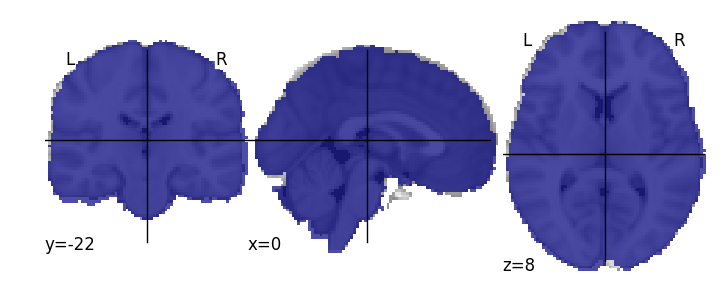

In [115]:
from nilearn import plotting
plotting.plot_roi(im)

In [121]:
task_output_dir

'C:\\data\\graduate_thesis\\hcp_data_test_gz\\output'

In [122]:
os.path.join(
        task_output_dir, "mask.nii.gz")

'C:\\data\\graduate_thesis\\hcp_data_test_gz\\output\\mask.nii.gz'

In [138]:
# group_mask = nibabel.Nifti1Image(
#     intersect_masks(mask_images), #.astype(np.int8),
#     nibabel.load(mask_images[0]).get_affine())
# nibabel.save(group_mask, os.path.join(
#         task_output_dir, "mask.nii.gz"))
# group_mask.to_filename(os.path.join(
#         task_output_dir, "mask.nii.gz"))    

# print("... done.\r\n")
# print("Group GLM")
# contrasts = subjects[0].contrasts
# subjects_effects_maps = [subject_data.effects_maps
#                          for subject_data in subjects]

group_one_sample_t_test(
    mask_images,
    subjects_effects_maps,
    contrasts,
    task_output_dir,
    threshold=threshold,
    cluster_th=cluster_th,
#     start_time=stats_start_time,
    subjects=[subject_data.subject_id for subject_data in subjects],
    title='Group GLM for HCP fMRI %s protocol (%i subjects)' % (
        protocol, len(subjects)),
    slicer=slicer
    )